# FOREST FIRE DETECTION USING COMPUTER VISION

### Importing Python libraries and modules essential for data analysis, visualization, machine learning, and deep learning. It includes tools for handling data (NumPy, Pandas), creating visualizations (Matplotlib, Seaborn), machine learning models (scikit-learn), deep learning architectures (Keras), image processing (OpenCV), and utility functions (tqdm for progress bars, glob for file pattern matching).

In [2]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob


from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking

from keras.utils import to_categorical



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### seting up a cache directory (~/.keras/models) to store pre-trained Keras models.Copies the Xception model files from a specified input(../input/keras-pretrained-models/) directory to the cache(~/.keras/models/) directory.


In [3]:
#copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#copy the Xception models
!cp ../input/keras-pretrained-models/xception* ~/.keras/models/
#show
!ls ~/.keras/models

cp: cannot stat '../input/keras-pretrained-models/xception*': No such file or directory


## Defining file paths for a forest fire detection and specifying two categories (fire_image and non_fire_image) and storing the number of categories

In [4]:
base_folder = '/home/avroop_rakehop/Desktop/GREEN-AI/forest_fire_detection_CV/fire_dataset'
data_folder = '/home/avroop_rakehop/Desktop/GREEN-AI/forest_fire_detection_CV/fire_dataset'
train_data_folder = '/home/avroop_rakehop/Desktop/GREEN-AI/forest_fire_detection_CV/fire_dataset/fire_images'
test_date_folder  = '/home/avroop_rakehop/Desktop/GREEN-AI/forest_fire_detection_CV/fire_dataset/non_fire_images'

categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)

## Iterates through the dataset categories (fire_images and non_fire_images), counting the images in each category and storing their labels. It creates a train_data list containing the image path, its numeric label, and its category name for further processing.

In [5]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])


2it [00:00, 1351.48it/s]


In [6]:
#show image count
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

fire_images -> 755
non_fire_images -> 244


In [7]:
#create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

(999, 3)

,file,id,label
0,fire_images/fire.689.png,0,fire_images
1,fire_images/fire.435.png,0,fire_images
2,fire_images/fire.423.png,0,fire_images
3,fire_images/fire.503.png,0,fire_images
4,fire_images/fire.294.png,0,fire_images


## UTILITY FUNCTION loads an image from a specified file path, resizes it to the given dimensions (size), and converts it into a numerical array suitable for processing with machine learning models.
## MASKING converts the input image from BGR to HSV color space and creates a binary mask that highlights pixels within a specified HSV range ([0, 0, 250] to [250, 255, 255]).
## SEGMENTING applies the mask created by create_mask_for_plant to the input image using bitwise operations. The result is an image where only the highlighted regions from the mask are retained, normalized by dividing pixel values by 255 for further processing.

In [8]:
#masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# UTILITY function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

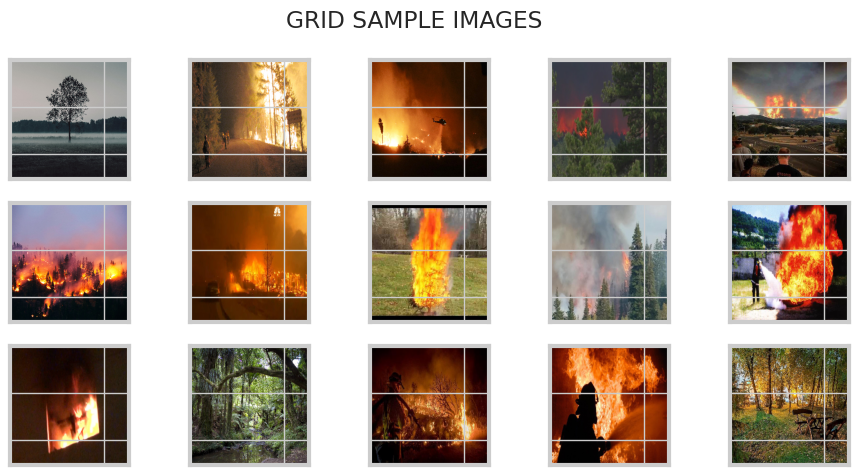

In [26]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('GRID SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

## Processesing and displaying an image through several stages: original image, mask creation, image segmentation, and image sharpening. Results are shown in a 1x4 grid with titles indicating each stage.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2723588..1.4911575].


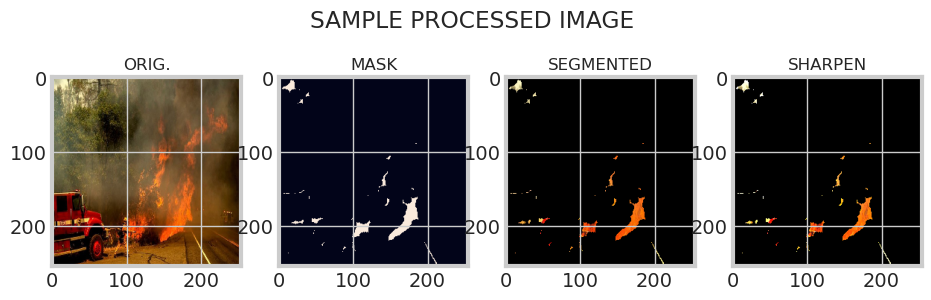

In [11]:
#get an image
img = read_img(df['file'][102],(255,255))
#mask
image_mask = create_mask_for_plant(img)
#segmentation
image_segmented = segment_image(img)
#sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)


ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);

## This code preprocesses images for model input by reading and resizing each image, applying segmentation and sharpening, and then normalizing it using Xception's preprocessing function. The processed images are stored in the X_train array for training a model.

In [12]:
INPUT_SIZE=255

##preprocess the input
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    #read image
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    #masking and segmentation
    image_segmented = segment_image(img)
    #sharpen
    image_sharpen = sharpen_image(image_segmented)
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x

999it [00:14, 67.56it/s] 


In [13]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)


Train Image Shape:  (999, 255, 255, 3)
Train Image Size:  194879925


## SPLITING THE DATA

In [14]:
y = df['id']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [15]:
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])


FIRE IMAGES ON TRAINING DATA:  610
NON-FIRE IMAGES ON TRAINING DATA:  189


## Using a pre-trained Xception model to extract features from the input data. It predicts features for the training and validation datasets (train_x and train_val), using average pooling to reduce the spatial dimensions of the input feature map. These extracted features can then be used for further model training or analysis.

In [16]:
##get the features
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


In [17]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)


Train Shape:  (799, 2048)
Train Size:  1636352
Validation Shape:  (200, 2048)
Validation Size:  409600


## DEEP-LEARNING MODEL
### It defines a simple neural network using Keras' Sequential model with three layers: a dense layer with 256 units, another dense layer with 64 units, and an output layer with 1 unit for binary classification.AND give models summary

In [18]:
#keras Sequential model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/home/avroop_rakehop/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541,057 (2.06 MB)

 Trainable params: 541,057 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

### Training the defined neural network model for 100 epochs using the training data (bf_train_x and y_train), with a batch size of 32. The model's weights are updated after each batch during the training process.

In [19]:
#train the model @ 100 epochs
history = model.fit(bf_train_x, y_train, epochs=100, batch_size=32);

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6817 - loss: 0.5822 
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.4278
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7811 - loss: 0.4326
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8165 - loss: 0.3784
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8386 - loss: 0.3641 
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8553 - loss: 0.3367
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8560 - loss: 0.3518
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8351 - loss: 0.3058
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8827 - loss: 0.2782
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8955 - loss: 0.2702
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8994 - loss: 0.2550 
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accura

## LOSS AND ACCURACY
### one showing the training loss over epochs and the other showing the training accuracy. 

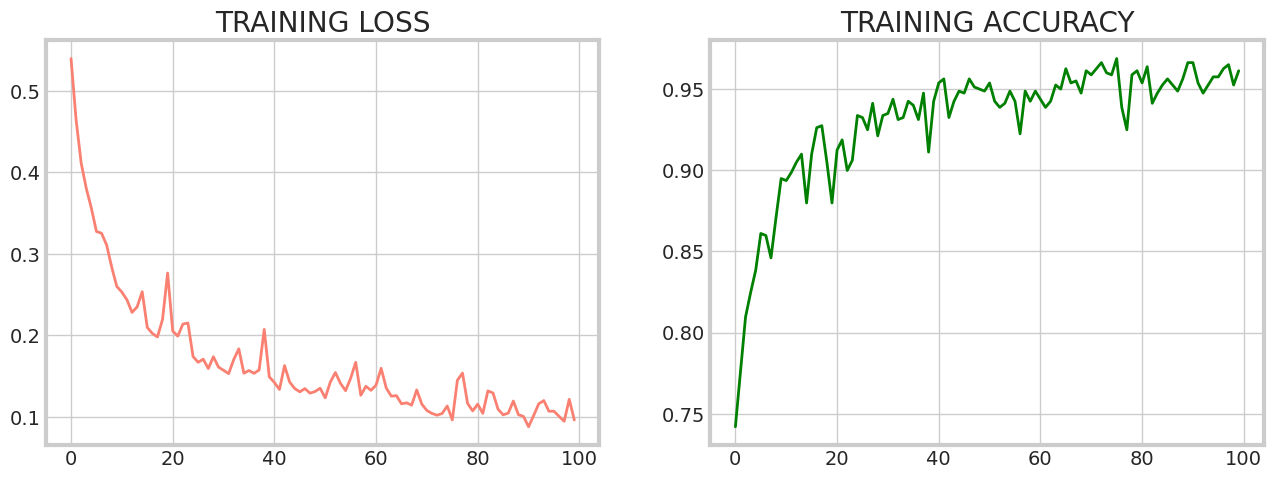

In [20]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

### Predicting the probabilities of each class for the validation data (bf_train_val) using the trained model.Then converting the probabilities into class predictions by selecting the index of the highest probability for each sample.

In [22]:
import numpy as np

# Get the predicted probabilities for each class
predictions_probabilities = model.predict(bf_train_val)

# Get the class predictions (the index of the maximum probability)
predictions = np.argmax(predictions_probabilities, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


## CLASSIFICATION REPORT

In [23]:
print(classification_report(y_val, predictions))


              precision    recall  f1-score   support

           0       0.72      1.00      0.84       145
           1       0.00      0.00      0.00        55

    accuracy                           0.72       200
   macro avg       0.36      0.50      0.42       200
weighted avg       0.53      0.72      0.61       200



/home/avroop_rakehop/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/avroop_rakehop/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/avroop_rakehop/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

### The classification report shows that the model performs well in identifying class 0, with high precision and recall, but struggles with class 1, having poor precision and recall. The overall accuracy is 72%, but the model's performance on class 1 needs improvement, as indicated by the low f1-score and recall for that class.

## CONFUSION MATRIX
### Generates and visualizes a confusion matrix for the validation predictions, with labeled axes representing the true and predicted classes (fire and non-fire images). The heatmap highlights the number of correct and incorrect classifications between the two classes.

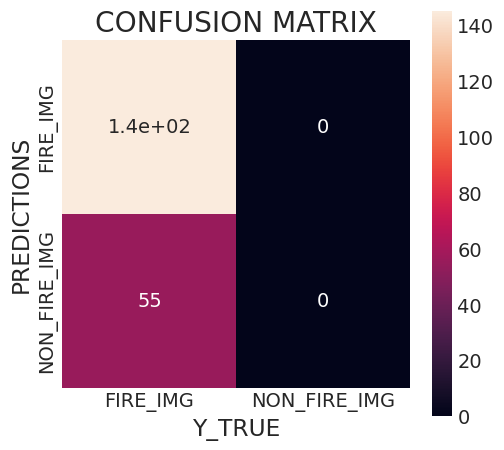

In [25]:
confusion_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize=(5,5))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=['FIRE_IMG', 'NON_FIRE_IMG'],
            xticklabels=['FIRE_IMG', 'NON_FIRE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");